In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pymc3 as pm

In [2]:
df = pd.read_csv("20190408_UWB1_UWB1_BRCA1/combined_results.csv")

In [3]:
def extract_data(df,i):
    from sklearn.preprocessing import LabelEncoder
    exp_idx = LabelEncoder().fit_transform(df['Experiment Title'])
    if( i>=0):
        mask =exp_idx==i
    else:
        mask = exp_idx>-1
    num_exp = len(np.unique(exp_idx))
    counts = df['Count'][mask].values
    concs  = df['Treatment'][mask].values
    cells_plated = df['Cells Plated'][mask].values
    return cells_plated,concs,counts,df.loc[mask,'Experiment Title'].unique()

### Fit a single data set

### Fit a single data set - logit transform


In [4]:
cells_plated,concs,counts,label = extract_data(df,5)

with pm.Model() as plated_model:
    #lPE_mu = pm.Normal("lPE_a",mu=-1.2,sd=0.5)
    #lPE_sd = pm.HalfNormal("lPE_dg",   sd=0.1)
    #lPE = pm.Normal('lPE',mu=lPE_mu,sd=lPE_sd)
    #PE  = pm.Deterministic('PE',1/(1+pm.math.exp(-lPE)))
    
    PE_a = pm.Lognormal("PE_a",2,0.2)
    PE_b = pm.Lognormal("PE_b",4,0.2)
    PE = pm.Beta("PE",alpha=PE_a,beta=PE_b)
    #PE = pm.Beta("PE",alpha=2,beta=4)#,shape=12)
    mu_attach = pm.Deterministic("mu_attach",cells_plated*PE)
    #mu_attach = cells_plated*0.2
    # model coefficents
    alpha = pm.Lognormal('alpha',mu=np.log(0.1),sd=0.4)
    beta  = pm.Lognormal('beta', mu=np.log(0.01),sd=0.4)
 
    #nb_alpha = pm.HalfNormal('nb_alpha',0.02)

    model = pm.Deterministic('model',mu_attach*pm.math.exp(-alpha*concs-(beta*concs)**2))
    #yi = pm.NegativeBinomial('yi',mu=model,alpha=1/nb_alpha**2,observed=counts)
    yi = pm.Poisson('yi',mu=model,observed=counts)

In [5]:
hm_test.PE_lo

NameError: name 'hm_test' is not defined

In [6]:
cells_plated,concs,counts,label = extract_data(df,5)
with plated_model:
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, PE, PE_b, PE_a]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:01<00:00, 2138.25draws/s]


In [7]:
print(label)
theta_med=[]
for var in 'PE alpha beta'.split():
    med = np.median(trace.get_values(var))
    print(med,pm.hpd(trace.get_values(var)))
    theta_med.append(med)

['UWB1 RNF20si#3']
0.08096925120533287 [0.0733387  0.08824842]
0.0687965948818243 [0.05968603 0.07875827]
0.00651365284159533 [0.00312318 0.01100379]


In [8]:
def model2(theta, X ):
    PE,alpha,beta = theta[:3]

    cells_plated = X[:,0]
    conc         = X[:,1]
    return cells_plated*PE*np.exp(-abs(alpha)*conc-(beta*conc)**2)

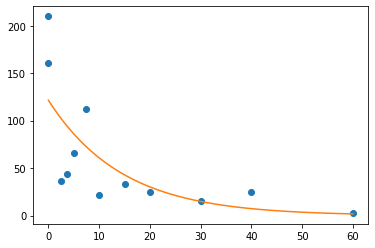

In [9]:
plt.plot(concs,counts,'o')
x=np.linspace(0,60,101)
Xp = np.stack([cells_plated[0]*np.ones_like(x),x],axis=1)
plt.plot(Xp[:,1],model2(theta_med,Xp))

### Fit whole dataset

In [4]:
from sklearn.preprocessing import LabelEncoder
exp_idx = LabelEncoder().fit_transform(df['Experiment Title'])
n1 = len(np.unique(exp_idx))
counts = df['Count'].values
ncount = len(counts)
concs  = df['Treatment'].values
cells_plated = df['Cells Plated'].values
labels = df['Experiment Title'].values


In [5]:

with pm.Model() as hm_test:

    # priors of level 1 distribution
    mu_lo_hp_l = pm.Normal    ('mu_lo_hp_l',    mu=-1.5,sd=2)
    mu_lo_hp_s = pm.HalfNormal('mu_lo_hp_s',    2)
    mu_lo_1 =  pm.Deterministic('mu_lo_1',            mu_lo_hp_l+mu_lo_hp_s*pm.Normal('mu_lo_1_t', mu=0, sd=1,shape=n1 ))
    
    
    # experiment level (centered dist)
    sd_lo_hp_l = pm.Normal    ('sd_lo_hp_l',   mu=0,sd=1 )
    sd_lo_hp_s = pm.Exponential('sd_lo_hp_s',   0.1)
    
    sd_lo_1 =  pm.Deterministic('sd_lo_1',pm.math.exp(sd_lo_hp_l+sd_lo_hp_s*pm.Normal('sd_lo_1_t', mu=0 ,sd=1,shape=n1 )))
    
    PE_lo = pm.Normal('PE_lo',mu=mu_lo_1[exp_idx], sd=sd_lo_1[exp_idx], shape=len(exp_idx))
    #PE_lo = pm.Deterministic('PE_lo',mu_lo_1[exp_idx])
    PE    = pm.Deterministic('PE', 1./(1+pm.math.exp( -PE_lo)) )

    mu_attach = pm.Deterministic("mu_attach",cells_plated*PE)
    
    
    # model coefficents
    alpha = pm.Lognormal('alpha',mu=np.log(0.15),sd=0.6,shape=n1)
    beta  = pm.Lognormal('beta', mu=np.log(0.01),sd=0.6,shape=n1)
    

    model = pm.Deterministic('model',mu_attach*pm.math.exp(-alpha[exp_idx]*concs-(beta[exp_idx]*concs)**2))
    #yi = pm.NegativeBinomial('yi',mu=model,alpha=1/nb_alpha**2,observed=counts)
    yi = pm.Poisson('yi',mu=model,observed=counts)

In [6]:
with hm_test:
    trace = pm.sample(start={'mu_lo_hp_l':-1.5})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha, PE_lo, sd_lo_1_t, sd_lo_hp_s, sd_lo_hp_l, mu_lo_1_t, mu_lo_hp_s, mu_lo_hp_l]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:09<00:00, 403.41draws/s]
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [25]:
df_fit = pd.DataFrame(columns=["Experiment Title,PE,PE_lo,PE_sd_lo,alpha,alpha_err,beta,beta_err,ind".split(',')])
df_fit.set_index("Experiment Title",inplace=True)

for il in np.unique(exp_idx):
    mask = exp_idx==il
    label = labels[exp_idx==il][0]
    for var in 'PE PE_lo '.split():
        vals = trace.get_values(var)[:,mask]
        df_fit.loc[label,var] =np.median(vals)
    for var in 'alpha beta sd_lo_1'.split():
        vals = trace.get_values(var)[:,il]
        df_fit.loc[label,var] =np.median(vals)        
    df_fit.loc[label,'ind']=il

In [26]:
df_fit

,PE,PE_lo,PE_sd_lo,alpha,alpha_err,beta,beta_err,ind,sd_lo_1
Experiment Title,,,,,,,,,
UWB1 AS,0.107321,-2.1184,NaN,0.0566163,NaN,0.0080076,NaN,0.0,0.486626
UWB1 BRCA1 AS,0.244868,-1.12617,NaN,0.0218644,NaN,0.00633679,NaN,1.0,0.473078
UWB1 BRCA1 RNF20si#1,0.111286,-2.07768,NaN,0.0247968,NaN,0.00660846,NaN,2.0,0.417350
UWB1 BRCA1 RNF20si#3,0.120529,-1.98743,NaN,0.0276825,NaN,0.00731569,NaN,3.0,0.504637
UWB1 RNF20si#1,0.0610936,-2.73231,NaN,0.0587163,NaN,0.00789499,NaN,4.0,0.534877
UWB1 RNF20si#3,0.059472,-2.76094,NaN,0.0545358,NaN,0.00801543,NaN,5.0,0.580549


In [9]:
def logit(x):
    return 1/(1+np.exp(-x))

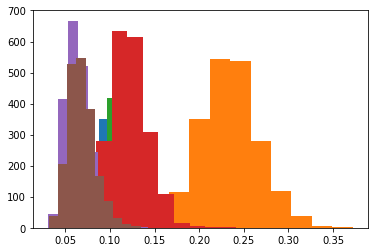

In [10]:
for i in np.unique(exp_idx):
    plt.hist(logit(trace.get_values('mu_lo_1')[:,i]))

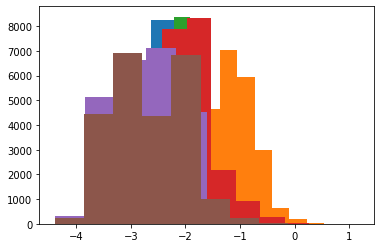

In [11]:
for i in np.unique(exp_idx):
    mask = exp_idx==i
    plt.hist(trace.get_values('PE_lo')[:,mask].flatten())

### New heading

In [12]:
Xp.shape

NameError: name 'Xp' is not defined

In [13]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
def perc_plot( ax, time, samp, **kwargs ):
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
    percs = np.percentile( samp, [2.5,25,50,75,97.5], axis=0)
    ax.fill_between( time, percs[0],percs[4], alpha=0.2, **kwargs )
    ax.fill_between( time, percs[1],percs[3], alpha=0.5, **kwargs )
    ax.plot( time, percs[2], lw=1.5, **kwargs )
    return

In [14]:

def plot_post( ax, df,exp_indx, trace, il):
    mask = exp_idx==il
    label=df['Experiment Title'][mask].unique()[0]

    cc = df['Treatment'].values[mask]
    isort = np.argsort(cc)
    cc=cc[isort]
    cp = df['Treatment'].values[mask][isort]
    
    nsamp= trace.get_values('alpha').shape[0]
    post_1=[]
    post_2=[]
    for i in range(500):
        isamp = np.random.randint(0,nsamp)
        cc    = concs[exp_idx==il]
        isort = np.argsort(cc)
        cc = cc[isort]
        cp    = cells_plated[exp_idx==il][isort]
        PE    = trace.get_values('PE')[isamp,exp_idx==il][isort]
        PE_m = logit(trace.get_values('mu_lo_1')[isamp,il])
        alpha = trace.get_values('alpha')[isamp,il]
        beta  = trace.get_values('beta')[isamp,il]
        post_1.append(cp*PE  *np.exp(-alpha*cc))
        post_2.append(cp*PE_m*np.exp(-alpha*cc))


    #perc_plot(ax,cc,post_1,color='red')
    perc_plot(ax,cc,post_2,color='green')

    ax.plot(cc,counts[mask][isort],'o',color='blue')
    ax.set_title(label)
    ax.grid()

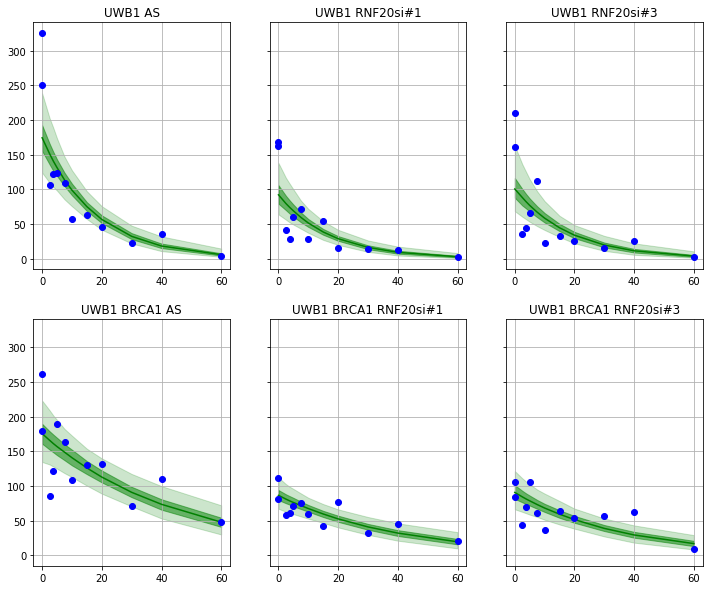

In [15]:
fig,axs = plt.subplots(2,3,sharey=True,figsize=(12,10))
for i,ii in enumerate([0,4,5]):
    ax=axs[0,i]
    plot_post( ax, df,exp_idx, trace, ii)
for i,ii in enumerate([1,2,3]):
    ax=axs[1,i]
    plot_post( ax, df,exp_idx, trace, ii)

(0, 0.45)

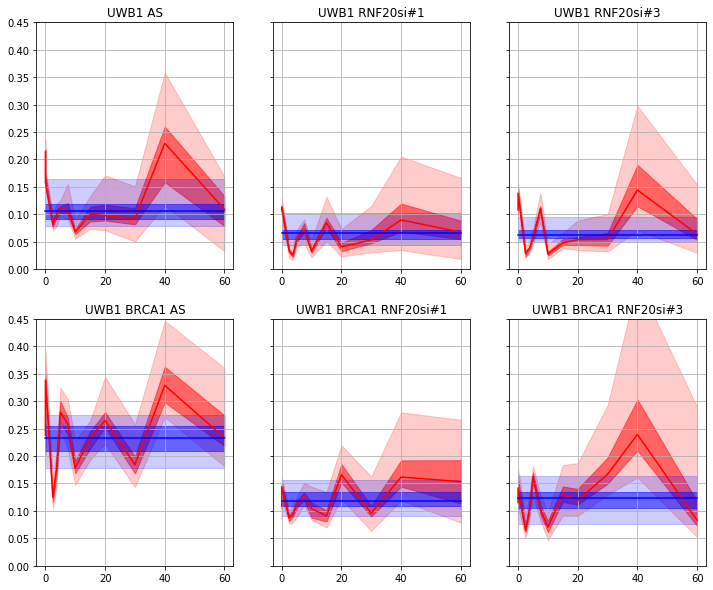

In [16]:
il=0
def plot_plating(ax,df,exp_idx, trace,il):
    mask = exp_idx==il
    label=df['Experiment Title'][mask].unique()[0]
    
    post1 = []
    post2 = []
    for i in range(50):
        isamp = np.random.randint(0,50)
        cc    = df['Treatment'].values[exp_idx==il]
        isort = np.argsort(cc)
        cc = cc[isort]
        cp    = df['Cells Plated'].values[exp_idx==il][isort]

        PE    = trace.get_values('PE')[isamp,exp_idx==il][isort]
        PE_m = logit(trace.get_values('mu_lo_1')[isamp,il])
        post1.append(PE)
        post2.appe96ones_like(cc))
    perc_plot(ax,cc,post1,color='red')
    perc_plot(ax,cc,post2,color='blue')
    ax.grid()
    ax.set_title(label)

fig,axs = plt.subplots(2,3,sharey=True,figsize=(12,10))
for i,ii in enumerate([0,4,5]):
    ax=axs[0,i]
    plot_plating( ax, df,exp_idx, trace, ii)
for i,ii in enumerate([1,2,3]):
    ax=axs[1,i]
    plot_plating( ax, df,exp_idx, trace, ii)
ax.set_ylim(0,0.45)

UWB1 AS
0.09832421850943983
[0.21587803 0.15335613 0.07779634 0.07955776 0.09471773 0.09414286
 0.04197607 0.08425399 0.07891395 0.05914922 0.11685694 0.07071171]


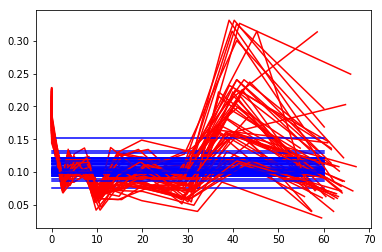

In [521]:
for i in range()

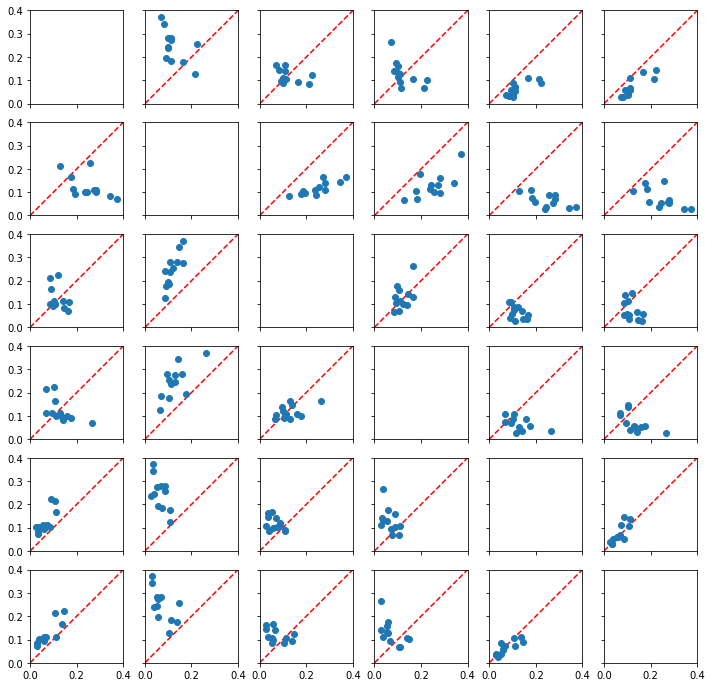

In [573]:
i1,i2=0,4
fig,axs = plt.subplots(6,6,sharex=True,sharey=True,figsize=(12,12))
for i in range(6):
    for j in range(6):
        ax = axs[i,j]
        
        ax.set_aspect('equal')
        ax.set_xlim(0,0.4)
        ax.set_ylim(0,0.4)
        
        if(i==j): continue
        ax.plot([0,0.5],[0.,0.5],'--',color='red')
        ax.plot( np.median(trace.get_values('PE'),axis=0)[exp_idx==i],np.median(trace.get_values('PE'),axis=0)[exp_idx==j],'o')
        
        

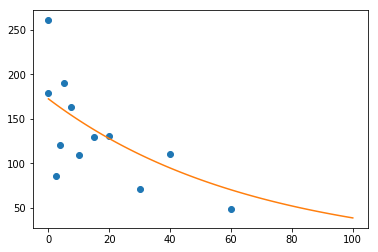

In [179]:
plt.plot( concs,counts,'o')

x=np.linspace(0,60,101)
Xp = np.stack([cells_plated[0]*np.ones_like(x),x],axis=1)
plt.plot( model2([0.23,0.025,0],Xp))

In [574]:
hm_test.mode

pymc3.model.Model